In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import math, random, time

In [2]:
from torch import nn

input_space = 3
N = 8
model = nn.Sequential(
      nn.Linear(input_space,64),
      nn.Mish(),
      nn.Linear(64,64),
      nn.Mish(),
      nn.Linear(64,N),
    )
opt = torch.optim.Adam(model.parameters(), lr=0.001)
quantile_tau = torch.tensor([(2*i+1)/(2*N) for i in range(0,N)], dtype=torch.float32)

C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def display_distribution(s):
    values = get_distribution(s).tolist()
    print(np.mean(values))
    print(values)
    values.sort()
    points = []
    sub_a = 1/N
    for v, next_v in zip(values, values[1:]):
        dv = next_v - v
        points.append([v,sub_a/dv])
        points.append([next_v,sub_a/dv])
    points = [*zip(*points)]
    plt.fill_between(points[0], points[1])
    plt.show()

def get_distribution(s):
    with torch.no_grad():
        values = model.forward(s)
    return values

def learn(s, r, s_next, done):
    opt.zero_grad()
    if done: next_values = torch.zeros(N)
    else: next_values = get_distribution(s_next)
    next_values = r + next_values

    pred_values = model.forward(s)
    td_e = next_values - pred_values
    huber_l = huber_loss(td_e)
    quantile_l = abs(quantile_tau -(td_e.detach() < 0).float()) * huber_l

    loss = quantile_l.mean()
    loss.backward()
    opt.step()

def huber_loss(td_e, k=1.0):
    loss = torch.where(td_e.abs() <= k, 0.5 * td_e.pow(2), k * (td_e.abs() - 0.5 * k))
    return loss       

-0.04849552968516946
[-0.02940377965569496, -0.1273898035287857, -0.059163663536310196, 0.04585444927215576, 0.0413503460586071, 0.0143180713057518, -0.12779779732227325, -0.1457320600748062]


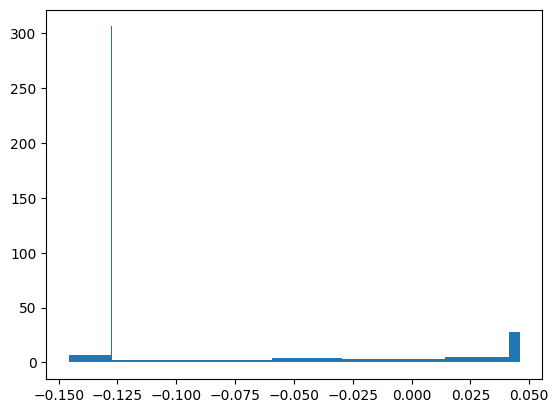

In [4]:
# initial distribution
display_distribution(torch.tensor([0.0,0.0,0.0]))

In [5]:
def train(episodes=1000):
    for ep in range(episodes):
        s = torch.zeros(input_space)
        r, done = 0, False
        for step in range(input_space):
            action = np.random.choice([-1, 1])
            s_next = s.clone()
            s_next[step] = action
            learn(s, r, s_next, done)
            s = s_next 
        for i in range(input_space):
            if s_next[-i-1].item() > 0: 
                r += 2**i
        done = True
        learn(s, r, None, done)

In [6]:
train()

341.02153807878494
[-6703.28955078125, -45.30083084106445, 4.7440314292907715, -4.108663082122803, -4.56026029586792, 4.501543045043945, 2793.36962890625, 6682.81640625]


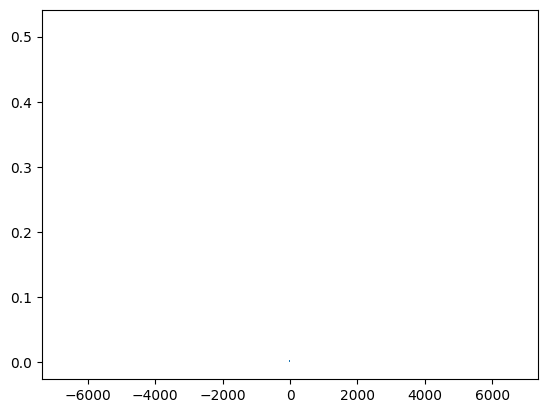

In [7]:
# inference
display_distribution(torch.tensor([0.0,0.0,0.0]))